#Initialization

##Required packages

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.0 MB/s eta 0:00:00


##Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
from transformers import BertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DefaultDataCollator
from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from nltk.stem import PorterStemmer
import torch

# Importing Data

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Internship/Remote Work on Twitter /labeled_data.csv" .

In [ ]:
df = pd.read_csv('/content/labeled_data.csv')

In [ ]:
train, test = train_test_split(df, test_size=0.1, random_state=1, stratify=df['position'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['position'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['tweet'].values.tolist(), train['position'].values.tolist()
x_valid, y_valid = valid['tweet'].values.tolist(), valid['position'].values.tolist()
x_test, y_test = test['tweet'].values.tolist(), test['position'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(1215, 23)
(135, 23)
(150, 23)


#EDA

In [ ]:
train.head()

,conversation_id,retweets_count,mentions,created_at,likes_count,in_reply_to_user_id,_id,source,user_id,in_reply_to_status_id,...,urls,tweet,hashtags,tweet_tokens,lemmatized_tweet,lemmatized_tweet_token,tweet_size,lemmatized_tweet_size,position,index_dup
0,1338075129377677315,0,NaN,2020-12-13 10:55:45+00:00,9,NaN,1338075129377677315,Twitter for Android,1183655208892715008,NaN,...,NaN,مزایای دورکاری جلسه مامانم اتاقم قلمو تند تند ...,[],"['مزایای', 'دورکاری', 'جلسه', 'مامانم', 'اتاقم...",مزایا دورکاری جلسه مامان اتاق قلمو تند تند ماس...,"['مزایا', 'دورکاری', 'جلسه', 'مامان', 'اتاق', ...",14,14,2,9212
1,803342886188228612,0,NaN,2016-11-28 21:00:44+00:00,0,NaN,803342886188228612,Marlik Jobs,733268097235222528,NaN,...,['http://job.marlik.ir/news/%da%a9%d8%a7%d8%b1...,کار منزل مهدی پلاست,[],"['کار', 'منزل', 'مهدی', 'پلاست']",کار منزل مهدی پلاس,"['کار', 'منزل', 'مهدی', 'پلاس']",4,4,1,32548
2,1280673095196520448,0,['990963720384909312'],2020-07-08 01:27:19+00:00,1,9.909637e+17,1280674795181404163,Twitter for iPhone,1113271427157725184,1.280674e+18,...,NaN,دورکاری,[],['دورکاری'],دورکاری,['دورکاری'],1,1,1,16242
3,1020178494171607041,0,['4839508725'],2018-07-20 06:29:38+00:00,1,4.839509e+09,1020193999028670465,Twitter for Android,838641367085527040,1.020178e+18,...,NaN,اینکارا دعا دورکاری مد بشه بشینیم خونه بچه ادم...,[],"['اینکارا', 'دعا', 'دورکاری', 'مد', 'بشه', 'بش...",اینکارا دعا دورکاری مد بشه بشینیم خونه بچه ادم...,"['اینکارا', 'دعا', 'دورکاری', 'مد', 'بشه', 'بش...",12,12,2,24344
4,1465616873001607171,0,['1289967190838358017'],2021-11-30 10:17:43+00:00,1,1.289967e+18,1465626086771810307,Twitter for Android,1262472862071492611,1.465617e+18,...,NaN,منی دوز واکسن زدم حاضر بیام تهران کار تحصیل دو...,[],"['منی', 'دوز', 'واکسن', 'زدم', 'حاضر', 'بیام',...",منی دوز واکسن زد حاضر بیام تهران کار تحصیل دور...,"['منی', 'دوز', 'واکسن', 'زد', 'حاضر', 'بیام', ...",17,17,1,45132


1    859
2    228
0    128
Name: position, dtype: int64
------------------------------------


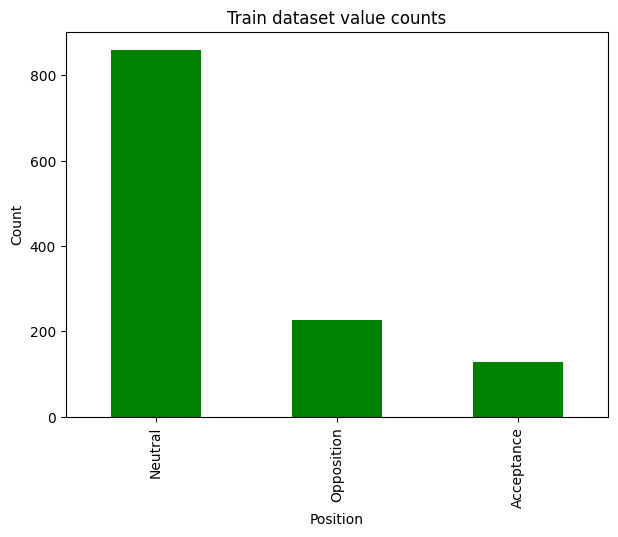

In [ ]:
print(train["position"].value_counts())
print("------------------------------------")
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.title("Train dataset value counts")
plt.xlabel("Position")
plt.ylabel("Count")
train["position"].value_counts().plot.bar(color='green')
plt.xticks([0, 1, 2], ["Neutral", "Opposition", "Acceptance"])
plt.show()

1    106
2     28
0     16
Name: position, dtype: int64
------------------------------------


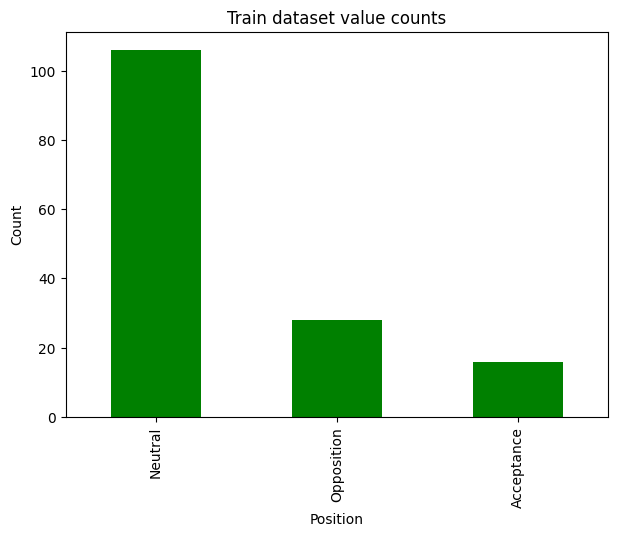

In [ ]:
print(test["position"].value_counts())
print("------------------------------------")
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.title("Train dataset value counts")
plt.xlabel("Position")
plt.ylabel("Count")
test["position"].value_counts().plot.bar(color='green')
plt.xticks([0, 1, 2], ["Neutral", "Opposition", "Acceptance"])
plt.show()

# Bert Classifier

In [ ]:
class BertClassifier:
    def __init__(self, model_address, train_column_name, test_column_name, batch_size=32, seq_len=128):
      df = pd.read_csv('/content/labeled_data.csv')
      df["position"] = df["position"].astype(str)
      self.train_df, self.test_df = train_test_split(df, test_size=0.1, random_state=1, stratify=df['position'])
      self.train_df, self.valid_df = train_test_split(train, test_size=0.1, random_state=1, stratify=train['position'])

      self.train_df = train.reset_index(drop=True)
      self.valid_df = valid.reset_index(drop=True)
      self.test_df = test.reset_index(drop=True)
      self.encoded_dict = {0 : 0, 1: 1, 2: 2}
      self.seq_len = seq_len
      self.model_address = model_address
      self.train_column_name = train_column_name
      self.test_column_name = test_column_name
      self.batch_size = batch_size
      self.prepare_data()
      self.set_model_and_tokenizer()

    def encode_classes(self, df):
      return df.position.map(self.encoded_dict)

    def prepare_data(self):
      self.train_df['position'] = self.encode_classes(self.train_df)
      self.valid_df['position'] = self.encode_classes(self.valid_df)
      self.test_df['position'] = self.encode_classes(self.test_df)

    def set_model_and_tokenizer(self):
      device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      if self.model_address == 'HooshvareLab/bert-base-parsbert-uncased':
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_address)
        self.bert = TFAutoModel.from_pretrained(self.model_address)
      elif self.model_address == 'xlm-roberta-base' or self.model_address == 'arm-on/BERTweet-FA':
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_address, from_pt=True)
        self.bert = TFAutoModel.from_pretrained(self.model_address, from_pt=True)

    def get_tokenized_ids(self, df, column_name):
      record_len = len(df)
      xinput_ids = np.zeros((record_len, self.seq_len))
      xmask_ids = np.zeros((record_len, self.seq_len))

      for i, row in df.iterrows():
        input_data = row[column_name]

        tokens = self.tokenizer.encode_plus(input_data, max_length=self.seq_len, truncation=True, return_attention_mask = True,
                                      padding='max_length', add_special_tokens=True, pad_to_max_length=True,
                                      return_tensors='tf')
        xinput_ids[i, :] = tokens['input_ids']
        xmask_ids[i, :] = tokens['attention_mask']

      class_values = df['position'].values
      labels = np.zeros((record_len, class_values.max()+1))
      labels[np.arange(record_len), class_values] = 1 #one-hot encoding

      return xinput_ids, xmask_ids, labels


    def dataset_mapper(self, input_ids, masks, labels):
      return {'input_ids': input_ids, 'attention_mask': masks}, labels


    def get_dataset(self, df, column_name):
      xinput_ids, xmask_ids, labels = self.get_tokenized_ids(df, column_name)
      dataset = tf.data.Dataset.from_tensor_slices((xinput_ids, xmask_ids, labels))
      dataset = dataset.map(self.dataset_mapper)
      return dataset.batch(self.batch_size, drop_remainder=True)

    def create_model(self):
      input_ids = tf.keras.layers.Input(shape=(self.seq_len,), name='input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(self.seq_len,), name='attention_mask', dtype='int32')

      embeddings = self.bert(input_ids, attention_mask=mask).pooler_output
      drop_output = tf.keras.layers.Dropout(0.7)(embeddings)
      output = tf.keras.layers.Dense(1024, activation='relu')(drop_output)
      y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(output)

      model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      #model.layers[2].trainable = False #for freezing bert layer
      optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
      loss = tf.keras.losses.CategoricalCrossentropy()
      acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
      model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
      print(model.summary())
      return model

    def train_and_evaluate_model(self, model):
      train_dataset = self.get_dataset(self.train_df, self.train_column_name)
      valid_dataset = self.get_dataset(self.valid_df, self.train_column_name)
      xinput_ids_test, Xmask_test, labels_test = self.get_tokenized_ids(self.test_df, self.test_column_name)
      history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)
      score = model.evaluate([xinput_ids_test, Xmask_test], labels_test, verbose=0)
      print("Loss on test data:", score[0])
      print("Accuracy on test data:", score[1])
      print("Classification Report:")
      predictions = np.argmax(model.predict([xinput_ids_test, Xmask_test]), axis=1)
      print(classification_report(self.test_df['position'], predictions, target_names=['0', '1', '2']))

      for i, classification in enumerate(["0", "1", "2"]):
        fpr, tpr, thresholds = metrics.roc_curve(np.array(self.test_df['position'].to_list()), np.array(predictions), pos_label=i)
        auc_res = metrics.auc(fpr, tpr)
        print(f"AUC - {classification}: ", auc_res)

      self.plot_results(history)
      self.print_confusion_matrix(self.test_df['position'].to_list(), predictions)
      return model, history, score, predictions

    def plot_results(self, history):
      plt.style.use('seaborn')
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_figheight(4)
      fig.set_figwidth(12)

      ax1.plot(history.history["accuracy"], label = "Train")
      ax1.plot(history.history["val_accuracy"], label ="Validation")
      ax1.set_ylabel("Accuracy")
      ax1.set_xlabel("Epoch")
      ax1.legend()

      ax2.plot(history.history["loss"], label = "Train")
      ax2.plot(history.history["val_loss"], label = "Validation")
      ax2.set_ylabel("Loss")
      ax2.set_xlabel("Epoch")
      ax2.legend()

      fig.suptitle(f"Results for {self.model_address} Model", fontsize="x-large", y=1.05)
      plt.tight_layout()
      plt.show()

    def print_confusion_matrix(self, y_test, y_pred):
      conf_mat = confusion_matrix(y_test, y_pred)
      ax = plt.subplot()
      sns.heatmap(conf_mat, annot = True, ax = ax, linewidths = 5, linecolor = 'y', center = 0)
      ax.set_title(f"Confusion Matrix for {self.model_address} Model")
      ax.set_xlabel('Predicted Labels')
      ax.set_ylabel('True Labels')
      ax.xaxis.set_ticklabels(['0', '1', '2'])
      ax.yaxis.set_ticklabels(['0', '1', '2'])
      plt.show()

##Parsbert

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1628413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

<ipython-input-31-267c9cc0ed95>:108: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


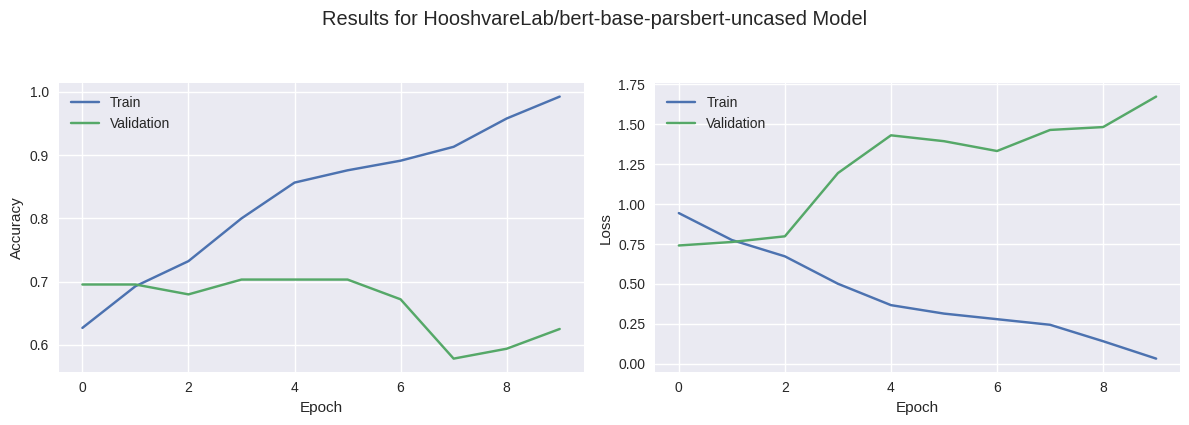

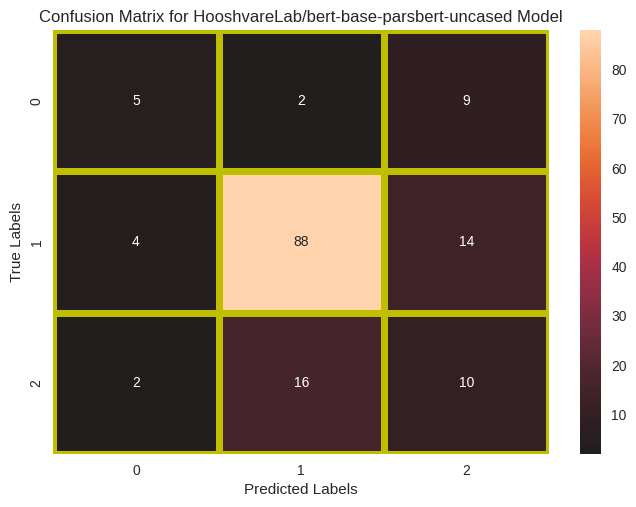

In [ ]:
classifier_ParsBert = BertClassifier('HooshvareLab/bert-base-parsbert-uncased', 'tweet', 'tweet', batch_size=32, seq_len=128)
part2_model = classifier_ParsBert.create_model()
part2_model, part2_history, part2_score, part2_predictions = classifier_ParsBert.train_and_evaluate_model(part2_model)

##BERTweet-FA

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1087879   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   68         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

<ipython-input-31-267c9cc0ed95>:108: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


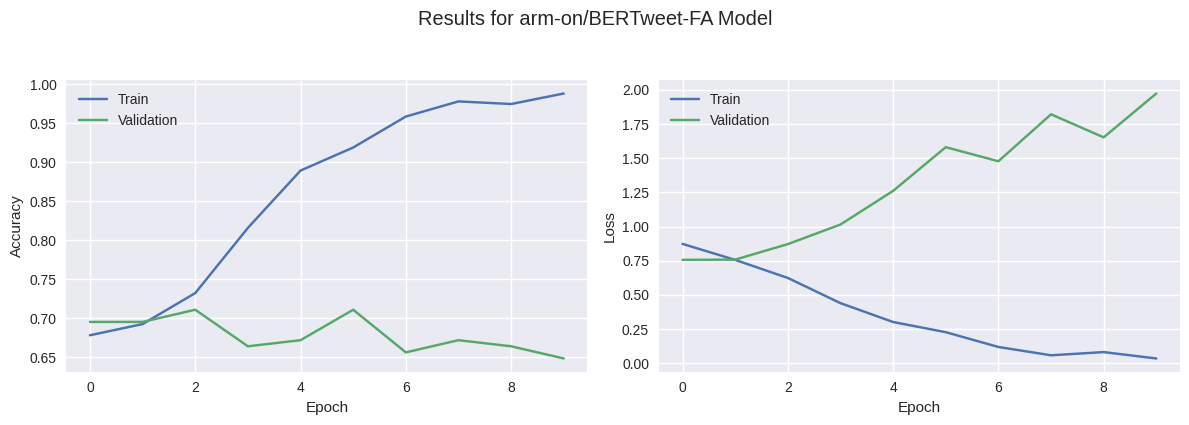

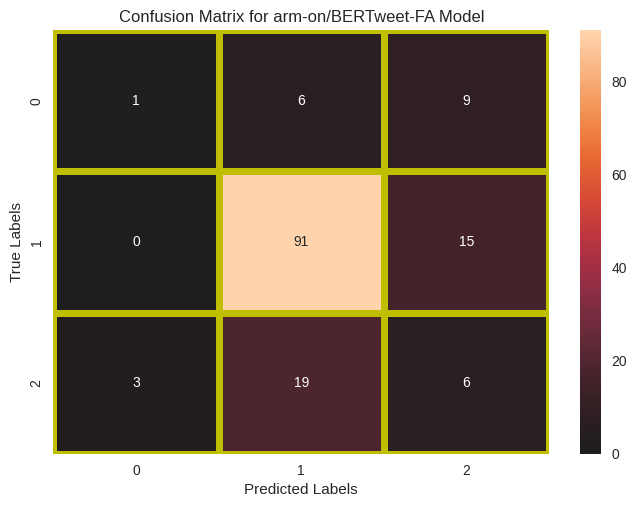

In [ ]:
classifier_BerteetFa = BertClassifier('arm-on/BERTweet-FA', 'tweet', 'tweet', batch_size=32, seq_len=128)
BerteetFa_model = classifier_BerteetFa.create_model()
BerteetFa_model, BerteetFa_history, BerteetFa_score, BerteetFa_predictions = classifier_BerteetFa.train_and_evaluate_model(BerteetFa_model)

##xlm-roberta

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_model (TFXLM  TFBaseModelOutputWithPooli   2780436   ['input_ids[0][0]',           
 RobertaModel)               ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-31-267c9cc0ed95>:108: MatplotlibDeprecationWarnin

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.71      1.00      0.83       106
           2       0.00      0.00      0.00        28

    accuracy                           0.71       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.50      0.71      0.59       150

AUC - 0:  0.5
AUC - 1:  0.5
AUC - 2:  0.5


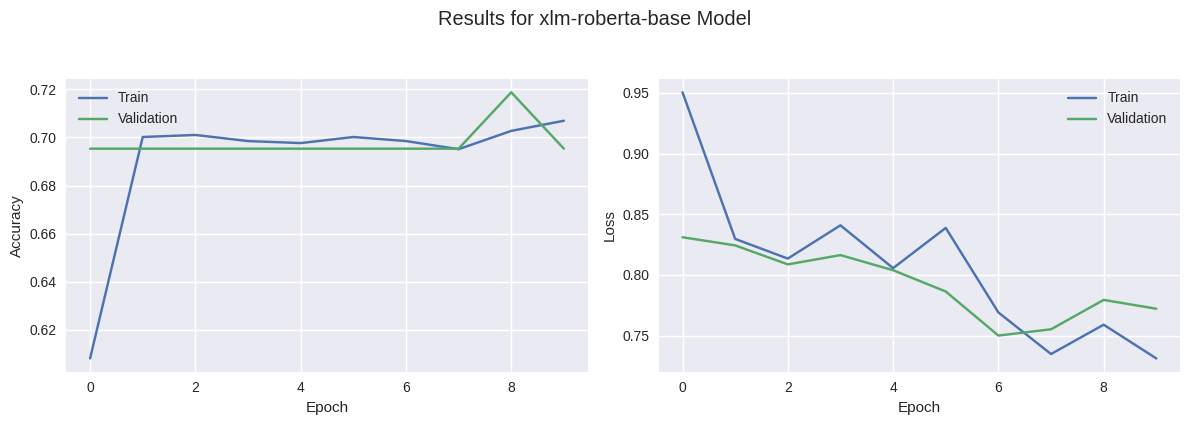

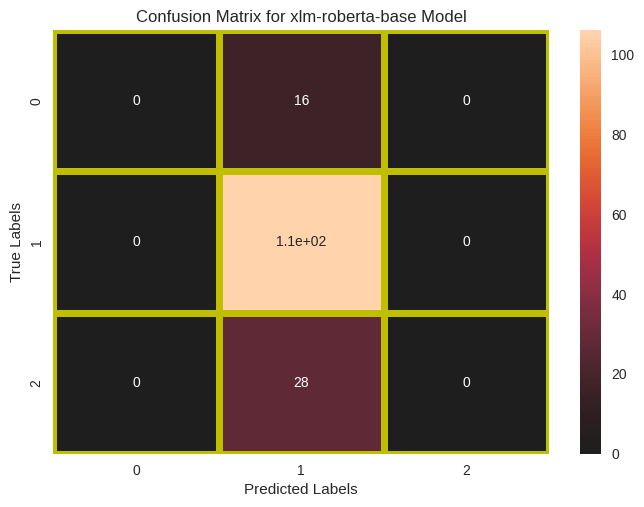

In [ ]:
classifier_xlm_roberta = BertClassifier('xlm-roberta-base', 'tweet', 'tweet', batch_size=32, seq_len=128)
xlm_roberta_model = classifier_xlm_roberta.create_model()
xlm_roberta_model, xlm_roberta_history, xlm_roberta_score, xlm_roberta_predictions = classifier_xlm_roberta.train_and_evaluate_model(xlm_roberta_model)